In [4]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

## Clean and Vectorize Data

In [5]:
# Clean the data Whoop whoop
df = pd.read_csv('data/train.csv')
df.drop('id', inplace=True, axis=1)
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

df['label'].replace(0, 'reliable', inplace=True)
df['label'].replace(1, 'unreliable', inplace=True)

train, test = train_test_split(df, test_size=0.5)
x_train = train['text']
y_train = train['label']
x_test = test['text']
y_test = test['label']

base_pipeline_steps = [
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
]

In [6]:
train.head()

,title,author,text,label
13699,Hands Off My Smiley Face: Emoji Become Corpora...,Amanda Hess,At last week’s Worldwide Developers Conference...,reliable
6838,STOP DRINKING STARBUCKS NOW! Just wait til You...,Danny Gold,90 \nO man! I cannot stand Starbucks. Why the ...,unreliable
1815,Voting Machine Shocker: Video Proof Election I...,Starkman,The Clinton campaign have found a way to rig v...,unreliable
17189,Globalists In Exile: ‘Party of Davos’ a Gloomy...,Matthew Boyle,The globalists in world politics and internati...,reliable
15783,Iraqis Who Flee Fighting in Falluja Find Hards...,Tim Arango,"AMIRIYAT FALLUJA, Iraq — One of the Iraqi c...",reliable


In [7]:
test.head()

,title,author,text,label
7711,Can Donald Trump Win? These Battleground Regio...,"Jonathan Martin, Alexander Burns, Trip Gabriel...",With Donald J. Trump pulling even or ahead of ...,reliable
13140,"Donald Trump Used Over $250,000 From Charity f...",Steve Eder,"Donald J. Trump, already under scrutiny for ho...",reliable
13777,The Matriarch Behind Beyoncé and Solange - The...,Alex Hawgood,"For sisters in the public eye, Beyoncé and Sol...",reliable
7396,"This Time, Anna Deavere Smith Cuts Close to Ho...",Kate Taylor,Anna Deavere Smith is coming home. The protean...,reliable
19836,Vanity Fair: National Politics Are all About D...,Neil Munro,The fate of Donald Trump’s presidency depends ...,reliable


## Classification

<mark>Only use one of the options—on run, it overrides the classifier variables.</mark>

### Option 1: Naïve Bayes

In [8]:
classifier_name = "naïve Bayes"
pipeline = Pipeline(base_pipeline_steps + [('clf', MultinomialNB())])

### Option 2: Stochastic Gradient Descent

In [9]:
classifier_name = "stochastic gradient descent"
pipeline = Pipeline(base_pipeline_steps + [
    ('clf', SGDClassifier(loss='perceptron', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
])

### Option 3: Passive Aggressive

In [10]:
classifier_name = "passive aggressive"
pipeline = Pipeline(base_pipeline_steps + [('clf', PassiveAggressiveClassifier(loss='squared_hinge'))])

## Train Classifier

In [11]:
pipeline.fit(x_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...       shuffle=True, tol=None, validation_fraction=0.1, verbose=0,
              warm_start=False))])

In [12]:
vectorizer = pipeline.steps[0][1]
classifier = pipeline.steps[2][1]

feature_weights = sorted(zip(classifier.coef_[0], vectorizer.get_feature_names()))
features = pd.DataFrame(feature_weights, columns=['weight', 'token'])

### Most Unreliable Features

In [13]:
features.head()

,weight,token
0,-6.621640,breitbart
1,-6.243089,said
2,-6.200821,2017
3,-5.994728,twitter
4,-5.692049,mr


### Most Reliable Features

In [14]:
features.tail()

,weight,token
112160,4.523658,november
112161,5.336946,hillary
112162,5.381276,october
112163,5.531814,2016
112164,6.712106,anti


## Evaluate Classifier Against Testing Data

In [15]:
prediction = pipeline.predict(x_test)

In [16]:
def outcome(row):
    if row['label'] == row['prediction']:
        return ''
    
    if row['prediction'] == 'unreliable':
        return 'false positive'
    
    return 'false negative'

test.loc[:,'prediction'] = prediction
test.loc[:,'outcome'] = test.apply(lambda row: outcome(row), axis=1)

accuracy = np.mean(prediction == y_test)

false_positives = test[test['outcome'] == 'false positive']
false_negatives = test[test['outcome'] == 'false negative']

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
print('classifier:', classifier_name)
print('accuracy:', accuracy)

classifier: passive aggressive
accuracy: 0.9608443618068467


In [18]:
num_false_positives = len(false_positives.index)
num_false_negatives = len(false_negatives.index)

print('%s misclassified documents of %s documents' % (num_false_positives + num_false_negatives, len(test.index)))
print('%s false positives' % num_false_positives)
print('%s false negatives' % num_false_negatives)

358 misclassified documents of 9143 documents
168 false positives
190 false negatives


## Visualize Classifications

In [19]:
summary = test.apply(lambda x: x.str.slice(0, 100))

def highlight_misclassfied(row):

    bg_color = 'white'
    text_color = 'black'
    
    if row['outcome'] != '':
        bg_color = 'red'
        text_color = 'white'

    return ['background-color: %s; color: %s;' % (bg_color, text_color)]*len(row.values)

summary.head().style.apply(highlight_misclassfied, axis=1)

,title,author,text,label,prediction,outcome
7711,Can Donald Trump Win? These Battleground Regions Will Decide - The New York Times,"Jonathan Martin, Alexander Burns, Trip Gabriel and Fernanda Santos","With Donald J. Trump pulling even or ahead of Hillary Clinton in a series of recent national polls,",reliable,reliable,
13140,"Donald Trump Used Over $250,000 From Charity for Business Disputes, Report Says - The New York Times",Steve Eder,"Donald J. Trump, already under scrutiny for how he uses his foundation, directed more than a quarter",reliable,reliable,
13777,The Matriarch Behind Beyoncé and Solange - The New York Times,Alex Hawgood,"For sisters in the public eye, Beyoncé and Solange Knowles have managed to resist the siren call to",reliable,reliable,
7396,"This Time, Anna Deavere Smith Cuts Close to Home - The New York Times",Kate Taylor,Anna Deavere Smith is coming home. The protean actress and playwright has spent her career interview,reliable,reliable,
19836,Vanity Fair: National Politics Are all About Donald Trump’s Wall - Breitbart,Neil Munro,The fate of Donald Trump’s presidency depends on whether Sen. Chuck Schumer can block construction o,reliable,reliable,


In [20]:
false_positives.head()

,title,author,text,label,prediction,outcome
12717,"Scarborough: 9th Circuit Ruling Is ’Laughable,...",Jeff Poor,"Friday on MSNBC’s “Morning Joe,” host Joe Scar...",reliable,unreliable,false positive
2532,Axios: Trump May Delay Infrastructure Plans to...,Breitbart News,The Trump Administration may put off any major...,reliable,unreliable,false positive
19110,Politico: Democrats in the Wilderness - Breitbart,Breitbart News,The 2016 presidential election was a day recko...,reliable,unreliable,false positive
10241,Border Numbers Up 31 Percent in One Month as ’...,Bob Price,The apprehension of illegal border crossers by...,reliable,unreliable,false positive
14983,Fake News! Newsweek Continues War on Steve Ban...,"Thomas D. Williams, Ph.D.","Watch out readers of Tolstoy and Dostoyevsky, ...",reliable,unreliable,false positive


In [21]:
false_negatives.head()

,title,author,text,label,prediction,outcome
3841,The BRUTAL Truth About Islamic Law The Left Wa...,TFPP Writer,You are here: Home / US / The BRUTAL Truth Abo...,unreliable,reliable,false negative
19173,Judge warns of dangers of appointed judiciary,Bob Unruh,Judge warns of dangers of appointed judiciary ...,unreliable,reliable,false negative
15916,New Watergate: Someone Bugged The Democratic N...,Grant Stern,Comments \nA new story about the cyber attack ...,unreliable,reliable,false negative
6285,"Netanyahu Calls Trump ‘True Friend Of Israel’,...",Geoffrey Grider,Netanyahu Calls Trump ‘True Friend Of Israel...,unreliable,reliable,false negative
16781,BREAKING: Trump Makes His Choice for Attorney ...,Top Right News,"By Top Right News on November 18, 2016 in Unca...",unreliable,reliable,false negative


In [22]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

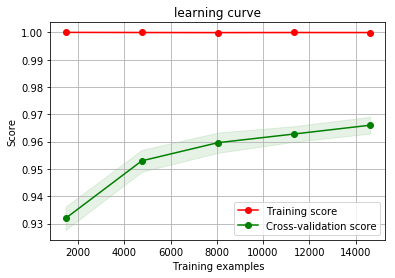

In [27]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(pipeline, "learning curve", df['text'], df['label'], cv=cv)